#### 1. Import libraries

In [3]:
# basic utility libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
#%matplotlib widget
%matplotlib inline

from matplotlib.image import imread
import tensorflow as tf
import cv2
from PIL import Image

#sky-kit learn (learning and optimisation helper libraries)
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

#keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Input, BatchNormalization
from scikeras.wrappers import KerasClassifier
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
#from keras.wrappers.scikit_learn import KerasClassifier (not in use)
from keras.optimizers import Adam
from keras.layers import Dropout
from keras.utils import to_categorical
from keras.metrics import Precision, Recall
from keras.callbacks import EarlyStopping 
from keras.preprocessing.image import ImageDataGenerator

import os, random
import glob
import seaborn as sns
import re 


2. Get dataset from Google drive for Collab Notebook

In [4]:
from google.colab import drive

link = 'https://drive.google.com/file/d/1CNPVX1rSLT03vI9KxrZdHPKU30v_0Mbm/view?usp=sharing'

drive.mount('/content/drive')

directory = '/content/drive/MyDrive/ML_dataset'

Mounted at /content/drive


#### 2. Importing training dataset 

In [5]:
from zipfile import ZipFile
file_name = '/content/drive/MyDrive/ML_dataset/dataset.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


2.1 Initial Analysis

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


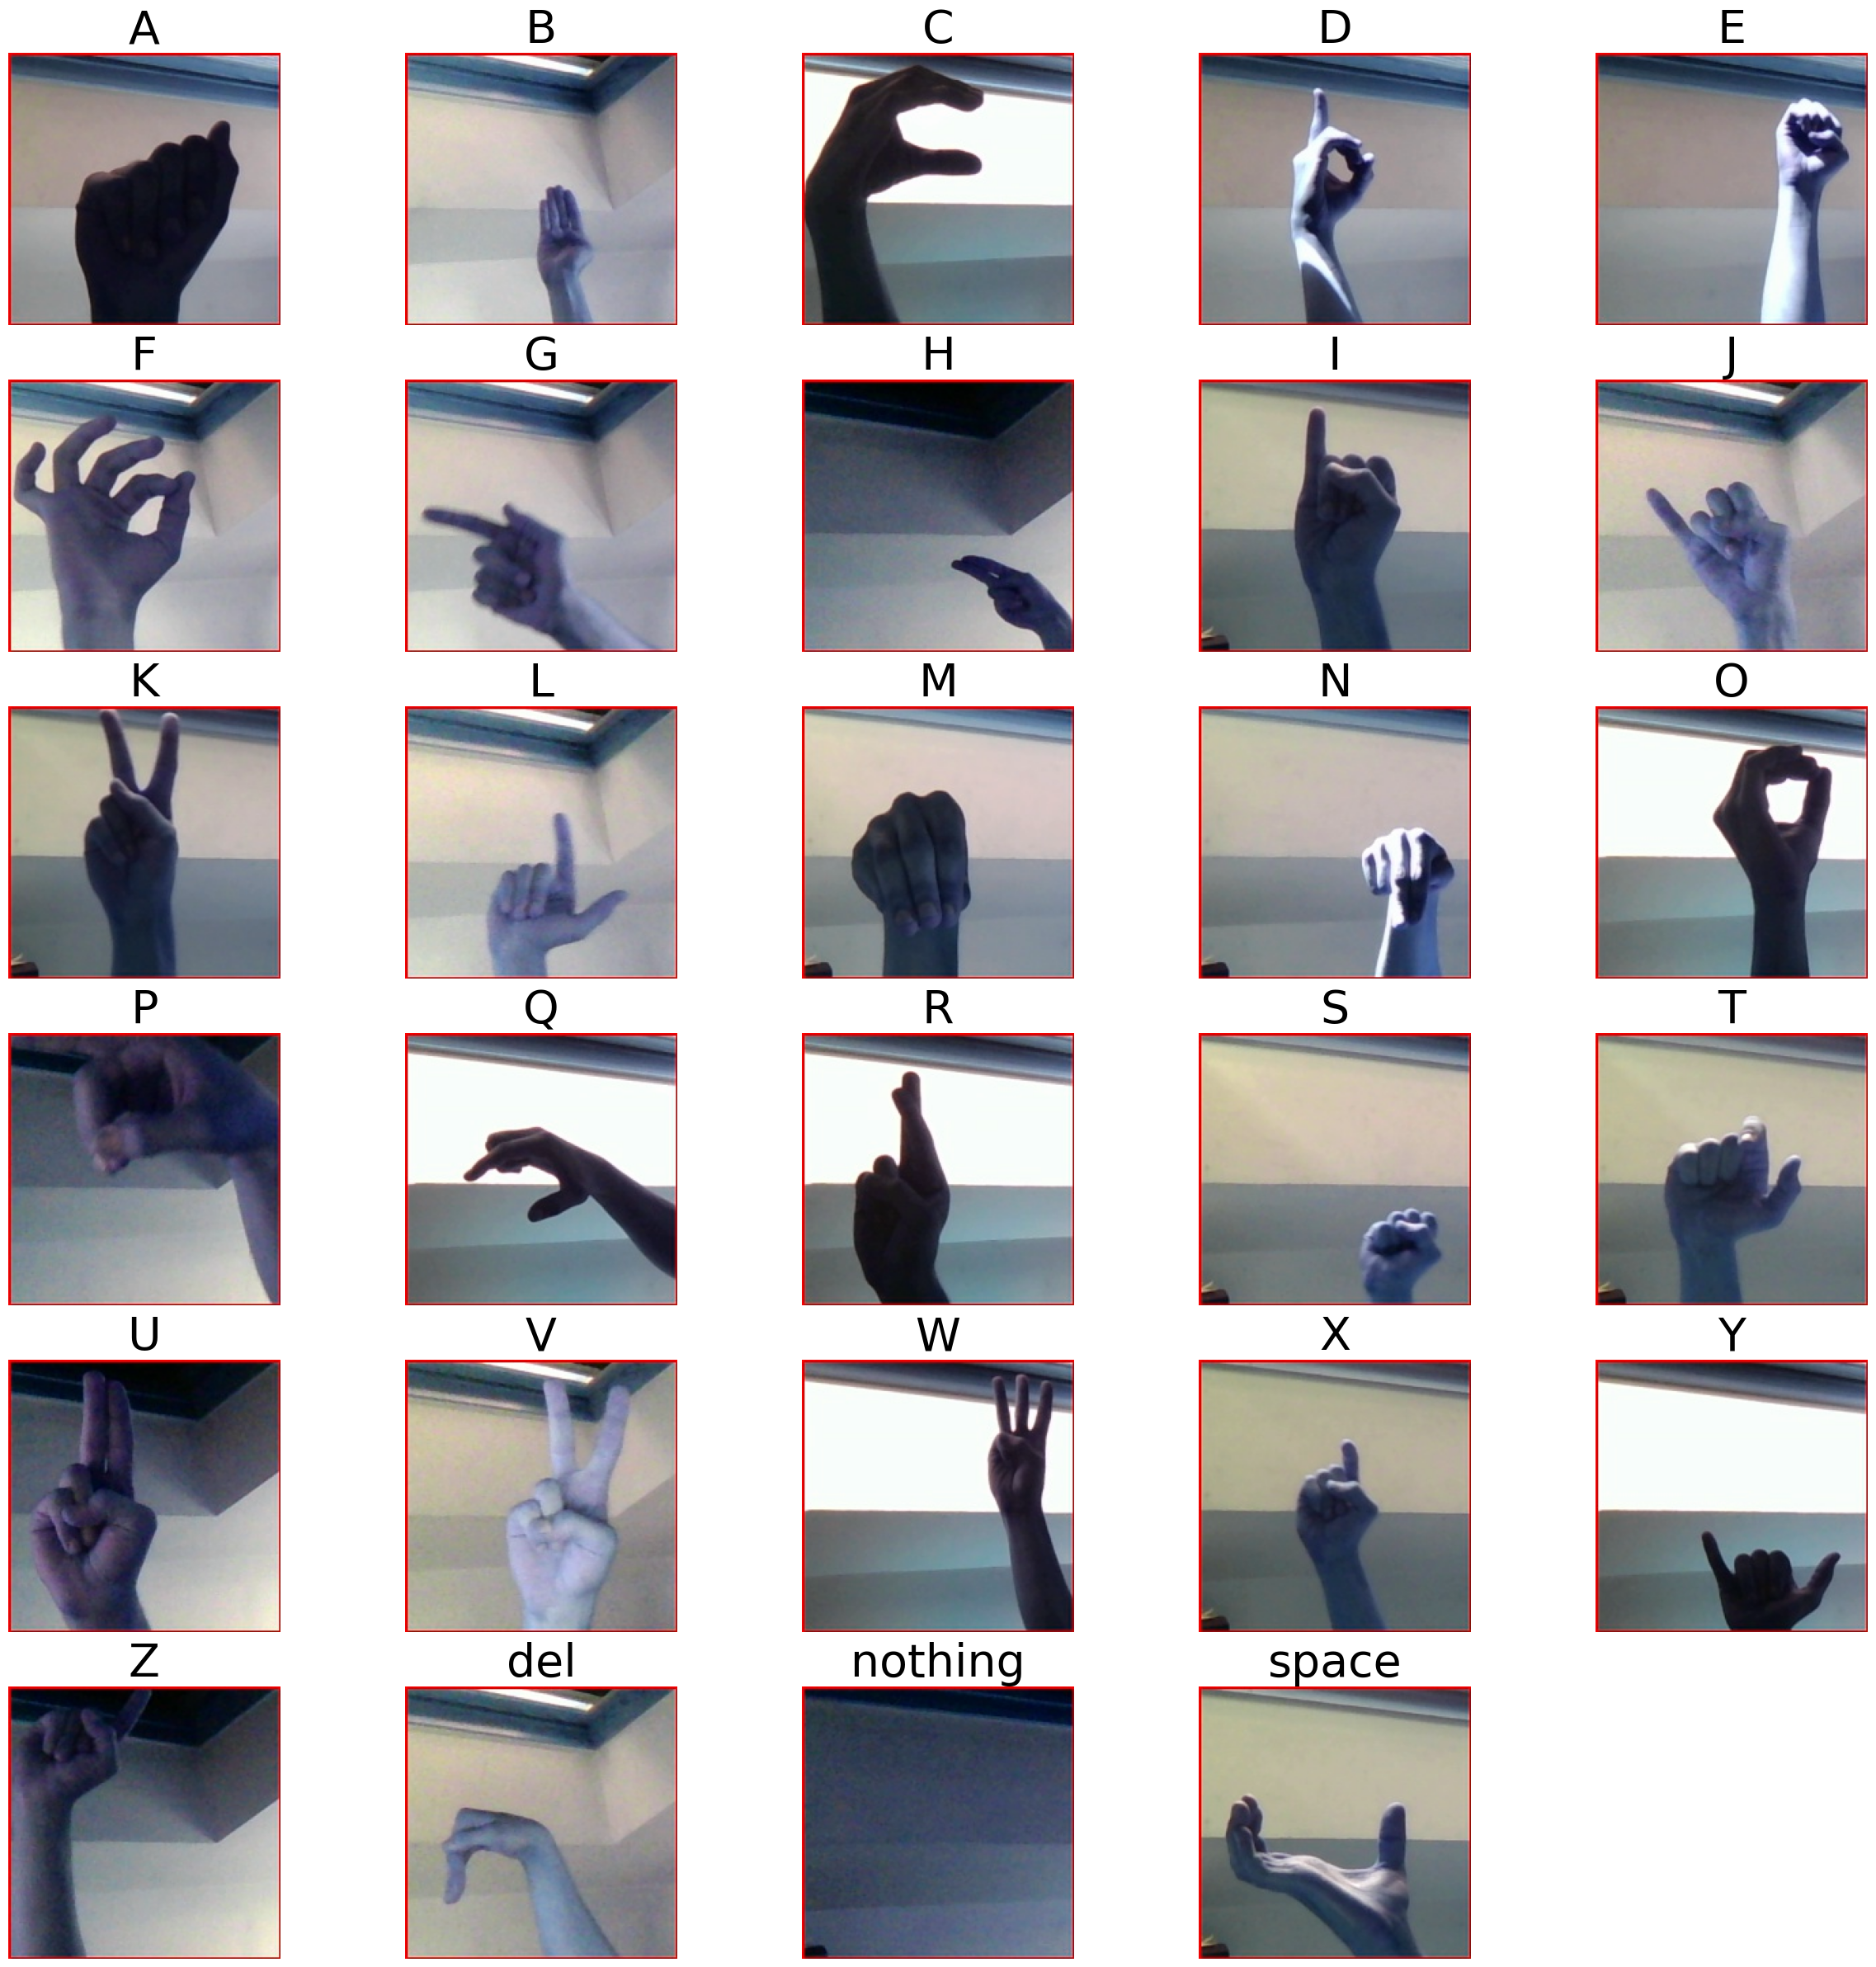

In [6]:
train_imgpath= '/content/dataset/asl_alphabet_train'

fig = plt.figure(figsize=(30, 30))

#Read lables from the train directory
read_labels= sorted(os.listdir(train_imgpath))

train_labels=[]
train_data=[]

print(read_labels)

for i, label in enumerate(read_labels):
    imgfile = random.choice(os.listdir(train_imgpath+'/'+label))
   #print(imgfile)
    image = cv2.imread(train_imgpath+'/'+label + '/' + imgfile) 
    plt.subplot(6,5,i+1)
    plt.axis("off")
    plt.imshow(image)
    plt.title(read_labels[i], fontsize=40)

plt.show()

2.1 Image Segmentation (Threasholding)

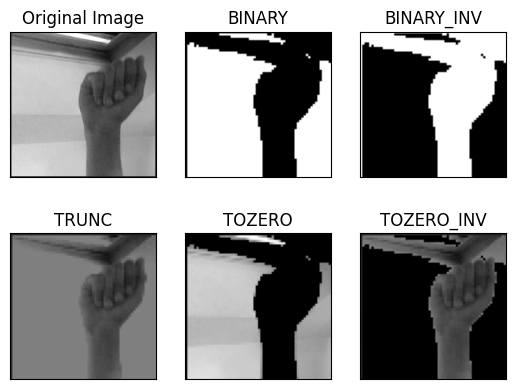

In [7]:
#Binary threasholding

img = cv2.imread('/content/dataset/asl_alphabet_train/A/A1111.jpg', cv2.IMREAD_GRAYSCALE)

resize_img = cv2.resize(img, (64,64))

#Trying different binary threshold methods to see which works best
r1,th1 = cv2.threshold(resize_img,127,255,cv2.THRESH_BINARY)
r2,th2 = cv2.threshold(resize_img,127,255,cv2.THRESH_BINARY_INV)
r3,th3 = cv2.threshold(resize_img,127,255,cv2.THRESH_TRUNC)
r4,th4 = cv2.threshold(resize_img,127,255,cv2.THRESH_TOZERO)
r5,th5 = cv2.threshold(resize_img,127,255,cv2.THRESH_TOZERO_INV)

#Titles for image to print
titles = ['Original Image','BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV']

#Image array to compare with original
images = [img, th1, th2, th3, th4, th5]

for i in range(6):
    plt.subplot(2,3,i+1),plt.imshow(images[i],'gray',vmin=0,vmax=255)
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

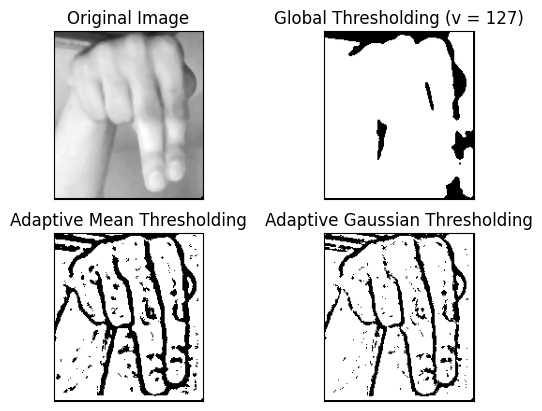

In [8]:
#Adaptive threasholding

img = cv2.imread('dataset/asl_alphabet_train/N/N1234.jpg', cv2.IMREAD_GRAYSCALE)

#Applied blur to avoid noise
img = cv2.medianBlur(img,5)

#Cropped some part of the image
img = img[20:,40:200]

#Applied different threasholding methods to check for best fit
ret,th1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
th2 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,11,2)
th3 = cv2.adaptiveThreshold(img,225,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)

#Titles for image to print
titles = ['Original Image', 'Global Thresholding (v = 127)',
            'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']

#Image array to compare with original
images = [img, th1, th2, th3]

for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()


2.3 Data Pre-processing

2.3.1 Pre-processing the images Train dataset

In [9]:
#Pre-process the images by applying the addaptive threasholding on train set

train_imgpath= '/content/dataset/asl_alphabet_train'
test_imgpath = '/content/dataset/asl_alphabet_test'
new_test_imagepath = '/content/dataset/asl_alphabet_new' #Impoted new data from kaggle as given dataset does has limited data. Details in the report
preprocessed_imgpath = '/content/dataset/asl_preprocessed'

os.mkdir(preprocessed_imgpath)

#Read lables from the train directory
read_labels= sorted(os.listdir(train_imgpath))

#Applying the mean blur and addaptive thresholding
for i, label in enumerate(read_labels):
    savedpath= preprocessed_imgpath +'/'+ label
    os.mkdir(savedpath)
    for imgfile in os.listdir(train_imgpath+'/'+label):
        img = cv2.imread(train_imgpath+'/'+label + '/' + imgfile,  cv2.IMREAD_GRAYSCALE) 
        img = cv2.medianBlur(img,5)
        img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)
        newsavedpath= os.path.join(savedpath, imgfile)
        cv2.imwrite(newsavedpath,img)

In [10]:
#Convert images into np arrays before feeding to model

train_imgpath= '/content/dataset/asl_alphabet_train'
test_imgpath = '/content/dataset/asl_alphabet_test'
new_test_imagepath = '/content/dataset/asl_alphabet_new' #Impoted new data from kaggle as given dataset does has limited data. Details in the report
preprocessed_imgpath = '/content/dataset/asl_preprocessed'

#Read lables from the train directory
read_labels= sorted(os.listdir(preprocessed_imgpath))

train_labels=[]
train_data=[]

print(read_labels)

for i, label in enumerate(read_labels):
    for imgfile in os.listdir(preprocessed_imgpath+'/'+label):
        img = cv2.imread(preprocessed_imgpath+'/'+label + '/' + imgfile) 
        image_from_array = Image.fromarray(img,'RGB')
        size_image = image_from_array.resize((64,64))
        train_data.append(np.array(size_image))
        train_labels.append(np.array(i))

X= np.array(train_data)
y=np.array(train_labels)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [ ]:
print(X.shape)
print(y.shape)

(87000, 64, 64, 3)
(87000,)


3. Hold out validation: Spliting the images into train and validation sets. Using 80:20 split

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,random_state=42)

Data-preprocessing on test set

In [22]:
new_test_imagepath = '/content/dataset/test_data' #Impoted new data from kaggle as given dataset does has limited data. Details in the report
test_preprocessed_imgpath = '/content/dataset/asl_preprocessed_test_latest'

os.mkdir(test_preprocessed_imgpath)

#Read lables from the train directory
read_labels= sorted(os.listdir(new_test_imagepath))

#read_labels.remove('asl-alphabet-test')


print(read_labels)

for i, label in enumerate(read_labels):
    savedpath= test_preprocessed_imgpath +'/'+ label
    os.mkdir(savedpath)
    for imgfile in os.listdir(new_test_imagepath+'/'+label):
        img = cv2.imread(new_test_imagepath+'/'+label + '/' + imgfile,  cv2.IMREAD_GRAYSCALE) 
        img = cv2.medianBlur(img,5)
        img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)
        #savedpath = os.listdir(savedpath)
        newsavedpath= os.path.join(savedpath, imgfile)
        cv2.imwrite(newsavedpath,img)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [23]:
test_preprocessed_imgpath = '/content/dataset/asl_preprocessed_test_latest'
#Read lables from the train directory
read_labels= sorted(os.listdir(test_preprocessed_imgpath))

print(type(read_labels))

#read_labels.remove('asl-alphabet-test')

test_labels=[]
test_data=[]


for i, label in enumerate(read_labels):
    for imgfile in os.listdir(test_preprocessed_imgpath+'/'+label):
       # print(imgfile)
        image = cv2.imread(test_preprocessed_imgpath+'/'+label + '/' + imgfile) 
        image_from_array = Image.fromarray(image,'RGB')
        size_image = image_from_array.resize((64,64))
        test_labels.append(np.array(size_image))
        test_data.append(np.array(i))

X_testdata= np.array(test_labels)
y_testdata=np.array(test_data)

<class 'list'>


 3.1 One-hot encoding: Encode lables in train and validation set to hot vectors

In [15]:
y_train_onehot= to_categorical(y_train, num_classes=29)
y_val_onehot = to_categorical(y_val, num_classes=29)

<Axes: xlabel='labels', ylabel='count'>

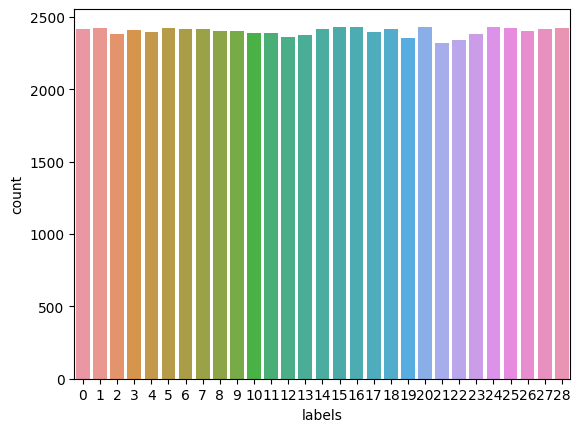

In [12]:
#Check the images in each class lable for train set
df_lab = pd.DataFrame()

df_lab["labels"] = y_train

sns.countplot(x=df_lab["labels"])


<Axes: xlabel='labels', ylabel='count'>

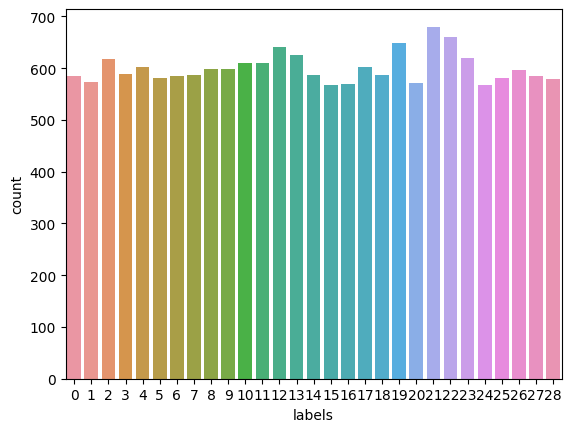

In [13]:
#Check the images in each class lable for validation set
df_lab = pd.DataFrame()

df_lab["labels"] = y_val

sns.countplot(x=df_lab["labels"])

3. Grid Search for tuning the hyperparameters.

3.1 Determine the layers and neurons in each layer

In [ ]:
def create_model(layers):
    #Define Model
    cnn = Sequential()
   
   #Add Convolution and Maxpool layers
    cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=5, padding="same", activation="relu", input_shape=[64, 64,3]))
    cnn.add(tf.keras.layers.Conv2D(filters=128, kernel_size=5, padding="same", activation="relu"))
    cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
    cnn.add(tf.keras.layers.Conv2D(filters=512, kernel_size=5, padding="same", activation="relu"))
    cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))

    #Flatten layer
    cnn.add(tf.keras.layers.Flatten())

    #Adding the dense layers
    for i, nodes in enumerate(layers):
        cnn.add(tf.keras.layers.Dense(units=nodes, activation='relu'))

    #Output Layer define with Softmax as activation layer      
    cnn.add(tf.keras.layers.Dense(units=29, activation='softmax'))
    
    #Compile the model with all layers, loss function and optimizer
    cnn.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return cnn

layers = [[32,64], (16,32,64), (32, 128,512)]
model = KerasClassifier(model=create_model, verbose=1, layers = layers)

param_grid = dict(layers=layers)

#Define the GridSearchCV with model and parameter list
grid = GridSearchCV(estimator=model, param_grid=param_grid, verbose=1)
grid_results = grid.fit(X_train,y_train_onehot, validation_data=(X_val, y_val_onehot))

#Print the model that has the best accuracy score
print("Best Results using: {0}, using {1}".format(grid_results.best_score_, grid_results.best_params_))

mean_score = grid_results.cv_results_['mean_test_score']
best_params = grid_results.cv_results_['params']

#Print the accuracy for other parameters
for mean_score, best_params in zip(mean_score, best_params):
    print('Accuracy of each input parameter: {0} ({1}) with: {2}'.format(mean_score, best_params))

3.2 Reduce the kernel size in Convolution layers

In [ ]:
def create_model(layers):
    #Define Model
    cnn = Sequential()
   
   #Add Convolution and Maxpool layers. Reduce the kernal size
    cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=[64, 64,3]))
    cnn.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"))
    cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
    cnn.add(tf.keras.layers.Conv2D(filters=512, kernel_size=3, padding="same", activation="relu"))
    cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))

    #Flatten layer
    cnn.add(tf.keras.layers.Flatten())

    #Adding the dense layers
    for i, nodes in enumerate(layers):
        cnn.add(tf.keras.layers.Dense(units=nodes, activation='relu'))

    #Output Layer define with Softmax as activation layer      
    cnn.add(tf.keras.layers.Dense(units=29, activation='softmax'))
    
    #Compile the model with all layers, loss function and optimizer
    cnn.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return cnn

layers = [[32,64], (16,32,64), (32, 128,512)]
model = KerasClassifier(model=create_model, verbose=1, layers = layers)

param_grid = dict(layers=layers)

#Define the GridSearchCV with model and parameter list
grid = GridSearchCV(estimator=model, param_grid=param_grid, verbose=1)
grid_results = grid.fit(X_train,y_train_onehot, validation_data=(X_val, y_val_onehot))

#Print the model that has the best accuracy score
print("Best Results using: {0}, using {1}".format(grid_results.best_score_, grid_results.best_params_))

mean_score = grid_results.cv_results_['mean_test_score']
best_params = grid_results.cv_results_['params']

#Print the accuracy for other parameters
for mean_score, best_params in zip(mean_score, best_params):
    print('Accuracy of each input parameter: {0} ({1}) with: {2}'.format(mean_score, best_params))

3.3 Determine the batch size

In [ ]:
def create_model(layers):
    #Define Model
    cnn = Sequential()
   
   #Add Convolution and Maxpool layers
    cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=[64, 64,3]))
    cnn.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"))
    cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
    cnn.add(tf.keras.layers.Conv2D(filters=512, kernel_size=3, padding="same", activation="relu"))
    cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))

    #Flatten layer
    cnn.add(tf.keras.layers.Flatten())

    #Adding the dense layers
    cnn.add(Dense(units=512, activation='relu'))
    cnn.add(Dense(units=256, activation='relu'))

    #Output Layer define with Softmax as activation layer      
    cnn.add(tf.keras.layers.Dense(units=29, activation='softmax'))
    
    #Compile the model with all layers, loss function and optimizer
    cnn.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return cnn

batch_size = [20,40]
model = KerasClassifier(model=create_model, verbose=1, layers = layers)

param_grid = dict(batch_size = batch_size)

#Define the GridSearchCV with model and parameter list
grid = GridSearchCV(estimator=model, param_grid=param_grid, verbose=1)
grid_results = grid.fit(X_train,y_train_onehot, validation_data=(X_val, y_val_onehot))

#Print the model that has the best accuracy score
print("Best Results using: {0}, using {1}".format(grid_results.best_score_, grid_results.best_params_))

mean_score = grid_results.cv_results_['mean_test_score']
best_params = grid_results.cv_results_['params']

#Print the accuracy for other parameters
for mean_score, best_params in zip(mean_score, best_params):
    print('Accuracy of each input parameter: {0} ({1}) with: {2}'.format(mean_score, best_params))

3.2 Determine the drop out rate

In [ ]:
def create_model(layers):
    #Define Model
    cnn = Sequential()
   
   #Add Convolution and Maxpool layers
    cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=[64, 64,3]))
    cnn.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"))
    cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
    cnn.add(tf.keras.layers.Conv2D(filters=512, kernel_size=3, padding="same", activation="relu"))
    cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))

    #Flatten layer
    cnn.add(tf.keras.layers.Flatten())

    #Adding the dense layers
    cnn.add(Dense(units=512, activation='relu'))
    cnn.add(Dense(units=256, activation='relu'))

    #Output Layer define with Softmax as activation layer      
    cnn.add(tf.keras.layers.Dense(units=29, activation='softmax'))
    
    #Compile the model with all layers, loss function and optimizer
    cnn.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return cnn

model = KerasClassifier(model=create_model, verbose=1, layers = layers)

#Define the drouout rate
drop_out = [0.0, 0.1, 0.2]
param_grid = dict(drop_out = drop_out)

#Define the GridSearchCV with model and parameter list
grid = GridSearchCV(estimator=model, param_grid=param_grid, verbose=1)
grid_results = grid.fit(X_train,y_train_onehot, validation_data=(X_val, y_val_onehot))

#Print the model that has the best accuracy score
print("Best Results using: {0}, using {1}".format(grid_results.best_score_, grid_results.best_params_))

mean_score = grid_results.cv_results_['mean_test_score']
best_params = grid_results.cv_results_['params']

#Print the accuracy for other parameters
for mean_score, best_params in zip(mean_score, best_params):
    print('Accuracy of each input parameter: {0} ({1}) with: {2}'.format(mean_score, best_params))

4. Final CNN Model

*   Convolution Layers + Relu: layers:3, kernal:3, Input: 64x64x3
*   Maxpooling layers: layers:2, kernal:2
*   Dense Layer + Relu: layers: 2
*   Output Layer + Softmax: 29 classes
*   Droupout rate: 0.1
*   Call Back Function: Early Stopping ( on validation loss with patience: 5)
*   Metrics: Accuracy, Precision, Recall 
*   Optimizer: Adam(lr=0.1)
*   Loss function: categorical_crossentropy
*   Epochs: 20
*   Batch Size=20






In [16]:
#Define Base Model
cnn = Sequential()

#Add convolution layers and Maxpool layers
cnn.add(Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=[64, 64,3]))
cnn.add(Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"))
cnn.add(MaxPool2D(pool_size=2, strides=2, padding='valid'))
cnn.add(Conv2D(filters=512, kernel_size=3, padding="same", activation="relu"))
cnn.add(MaxPool2D(pool_size=2, strides=2, padding='valid'))

#Add Flatten Layer
cnn.add(Flatten())

#Add dense layers with dropout rate
cnn.add(Dense(units=256, activation='relu'))
cnn.add(Dropout(0.1))
cnn.add(Dense(units=128, activation='relu'))
cnn.add(Dropout(0.1))

#Add output layer
cnn.add(Dense(units=29, activation='softmax'))

#Add callback function as earlystopper
earlystopper = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

#Define optimizer Adam with learning rate 
optimizer = Adam(learning_rate=0.1)

# compile the model
cnn.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy',Precision(), Recall()])

#Fit the model on train and validation set for 20 epochs
history = cnn.fit(X_train, y_train_onehot, batch_size=20, epochs=20,validation_data=(X_val, y_val_onehot), callbacks=earlystopper)

Epoch 1/20
3480/3480 [==============================] - 113s 28ms/step - loss: 1.3701 - accuracy: 0.7501 - precision_1: 0.8601 - recall_1: 0.6894 - val_loss: 0.2157 - val_accuracy: 0.9297 - val_precision_1: 0.9477 - val_recall_1: 0.9100
Epoch 2/20
3480/3480 [==============================] - 100s 29ms/step - loss: 0.2628 - accuracy: 0.9165 - precision_1: 0.9307 - recall_1: 0.9053 - val_loss: 0.1300 - val_accuracy: 0.9578 - val_precision_1: 0.9635 - val_recall_1: 0.9540
Epoch 3/20
3480/3480 [==============================] - 95s 27ms/step - loss: 0.2099 - accuracy: 0.9367 - precision_1: 0.9456 - recall_1: 0.9307 - val_loss: 0.1339 - val_accuracy: 0.9567 - val_precision_1: 0.9626 - val_recall_1: 0.9505
Epoch 4/20
3480/3480 [==============================] - 99s 29ms/step - loss: 0.1586 - accuracy: 0.9550 - precision_1: 0.9597 - recall_1: 0.9515 - val_loss: 0.1491 - val_accuracy: 0.9575 - val_precision_1: 0.9618 - val_recall_1: 0.9544
Epoch 5/20
3480/3480 [==============================] 

In [17]:
#Print the model summary
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 128)       36992     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 512)       590336    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 512)      0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 131072)           

4.1 Predict the model for validation set to get the accuracy and confuion matrix

In [18]:
#Fit model for validation set
y_val_pred = cnn.predict(X_val)

#Use np.argmax to get the maximum values along row axis
y_preds = np.argmax(y_val_pred,axis=1)

544/544 [==============================] - 5s 8ms/step


5. Analysis: Plot the accuracy vs epochs and loss vs epochs graphs for training and test set using matplotlib 

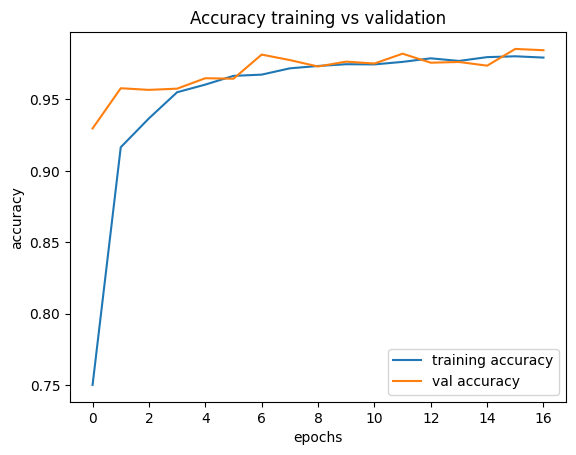

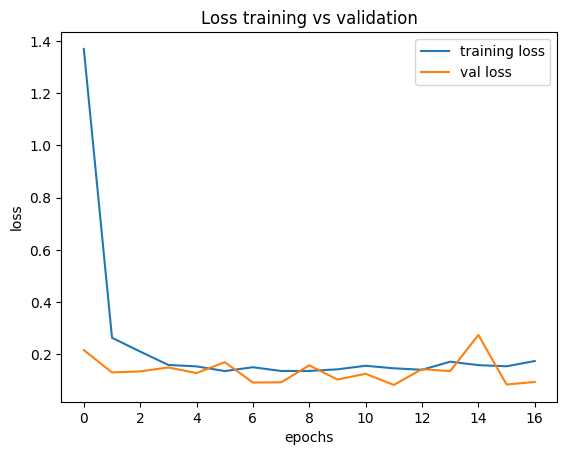

In [20]:
#fig, axes = plt.subplots(1,2, figsize=(15,15))

plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy training vs validation')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss training vs validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

5.1 Analysis: Check model accuracy and analyse the confusion matrix

0.953986644744873


Text(0.5, 1.0, 'CNN Confusion Matrix Validation Dataset')

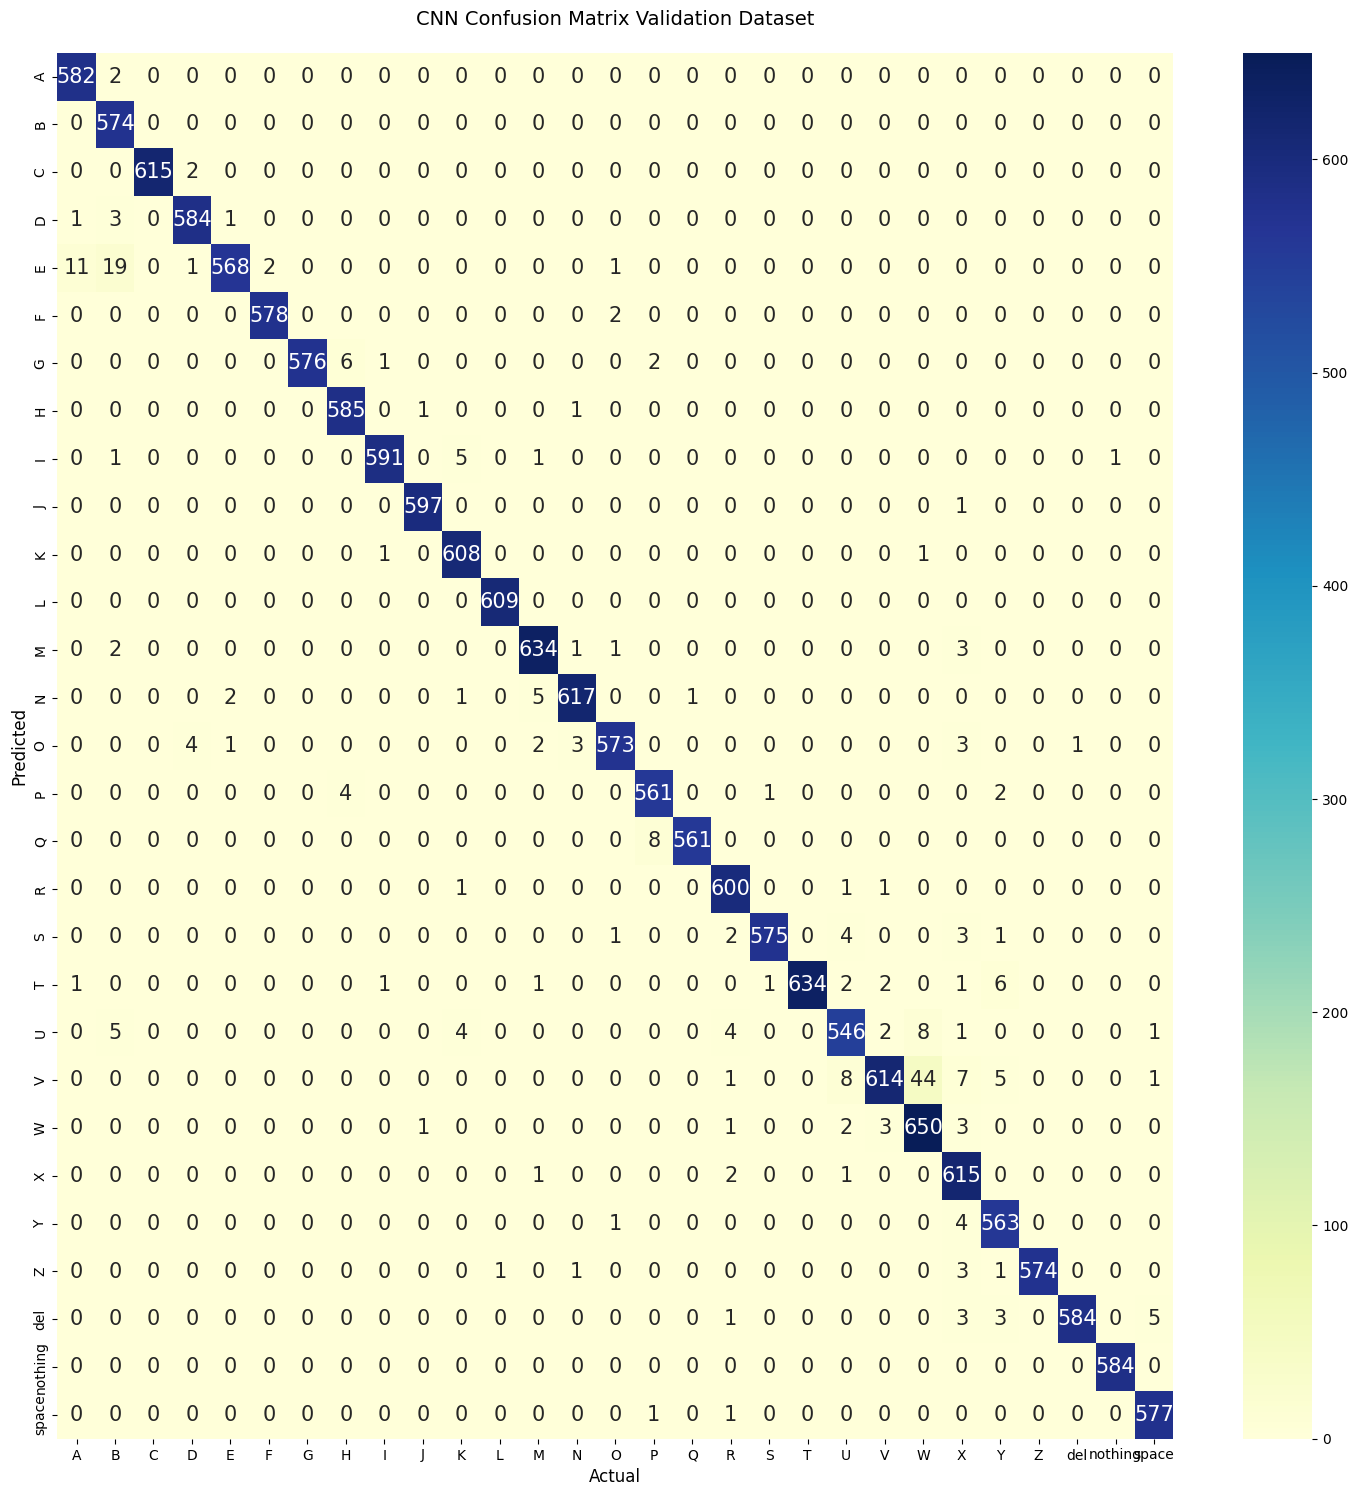

In [21]:
print(np.mean(history.history['accuracy']))

#Confusion Matrix validation data set
con_matrix_val = confusion_matrix(y_val, y_preds)

fig, ax = plt.subplots(figsize=(18, 18))

axes = sns.heatmap(con_matrix_val, annot=True, cmap="YlGnBu", fmt='g', annot_kws={"size": 15})

axes.set_xlabel('Actual', fontsize=12)
axes.set_ylabel('Predicted', fontsize=12)

# Ticket labels
axes.xaxis.set_ticklabels(read_labels)
axes.yaxis.set_ticklabels(read_labels)

axes.set_title('CNN Confusion Matrix Validation Dataset', fontsize=14, pad=20)

6. Predict the classes for test dataset using trained model

In [24]:
#predict the model
y_pred = cnn.predict(X_testdata)

#Using np.argmax to get the maximum value for row axis
vd_preds = np.argmax(y_pred,axis=1)

182/182 [==============================] - 2s 9ms/step


7. Analysis Print the accuracy and classification report 

In [25]:
#Print the model accuracy 
accu_score = accuracy_score(y_testdata, vd_preds)

print('Accuracy score for test set:{0}'.format(accu_score))

Accuracy score for test set:0.7981034482758621


In [26]:
from sklearn.metrics import classification_report
print(classification_report(y_testdata, vd_preds))

              precision    recall  f1-score   support

           0       0.98      0.50      0.66       200
           1       0.54      0.55      0.54       200
           2       0.92      0.61      0.74       200
           3       0.36      0.59      0.45       200
           4       0.61      0.94      0.74       200
           5       0.46      0.47      0.47       200
           6       0.52      0.47      0.49       200
           7       0.89      0.49      0.63       200
           8       0.76      0.46      0.57       200
           9       0.95      0.58      0.72       200
          10       0.88      0.56      0.69       200
          11       0.95      0.66      0.78       200
          12       0.96      1.00      0.98       200
          13       0.99      0.98      0.99       200
          14       0.64      0.79      0.71       200
          15       0.49      0.95      0.65       200
          16       0.92      0.97      0.94       200
          17       0.93    

7.1 Analysis: Plot the confusion matrix of the predicted classes for test set

Text(0.5, 1.0, 'CNN Confusion Matrix')

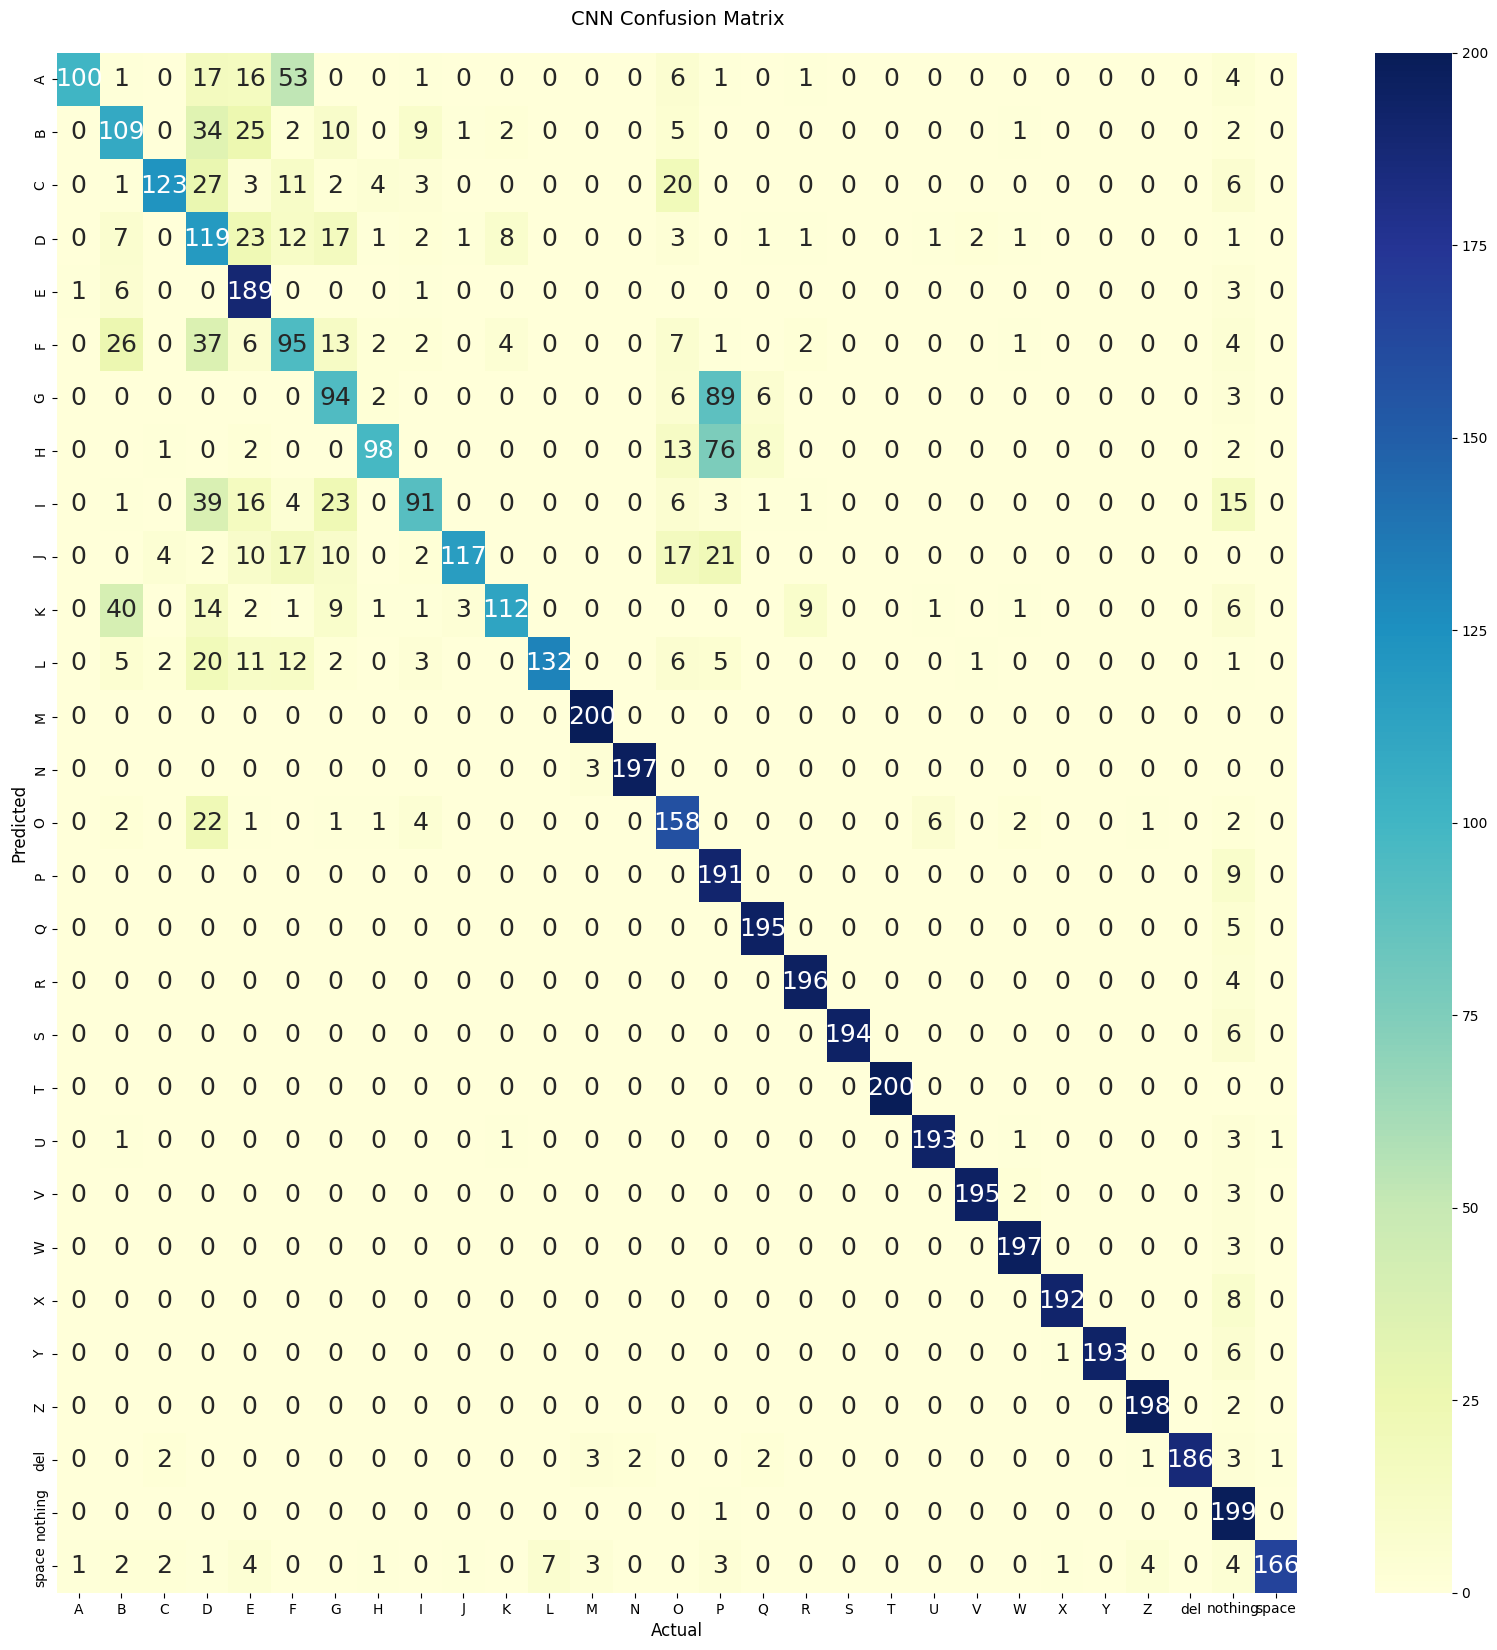

In [27]:
#Confusion Matrix
con_matrix = confusion_matrix(y_testdata, vd_preds)

#Plot using seaborn
f, ax = plt.subplots(figsize=(20, 20))

axes = sns.heatmap(con_matrix, annot=True, cmap="YlGnBu", fmt='g', annot_kws={"size": 18})

axes.set_xlabel('Actual', fontsize=12)
axes.set_ylabel('Predicted', fontsize=12)

axes.xaxis.set_ticklabels(read_labels)
axes.yaxis.set_ticklabels(read_labels)

axes.set_title('CNN Confusion Matrix', fontsize=14, pad=20)